In [1]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
# import dataset
df = pd.read_pickle('new_spin_glass_dataset.pkl')

# separation between features and targets
X = df[['J', 'T']].values
y = df[['energy', 'q_EA']].values

# separation between J and T
X_J = np.stack(df['J'].values)
X_T = df['T'].values.reshape(-1, 1)

# concatenation to create the input in the Feed Forward Network
X = np.hstack((X_J, X_T))

# conversion in PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# creating dataset
dataset = TensorDataset(X, y)

# creating training, val, and test
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # 10% for test

train_dataset, temp_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# creating the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# print sets cardinality
print(f"Cardinality training set: {len(train_dataset)}")
print(f"Cardinality del validation set: {len(val_dataset)}")
print(f"Cardinality del test set: {len(test_dataset)}")

Cardinality training set: 22960
Cardinality del validation set: 6560
Cardinality del test set: 3280


In [3]:
last_sample = dataset[32799]
print("last input sample shape (X):", last_sample[0].shape)
print("last target sample shape (y):", last_sample[1].shape)

last input sample shape (X): torch.Size([61])
last target sample shape (y): torch.Size([2])


In [4]:
# definition of my neural network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(input_size, input_size // 2)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(input_size // 2, input_size // 2)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(input_size // 2, 2)  # Output layer

    def forward(self, x):
        x = self.tanh1(self.fc1(x))
        x = self.tanh2(self.fc2(x))
        x = self.tanh3(self.fc3(x))
        x = self.fc4(x)
        return x


In [7]:
input_size = X.shape[1] # 61
model = FeedForwardNN(input_size)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# print the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The total number of trainable parameters is:", total_params)


The total number of trainable parameters is: 6634


In [6]:
num_epochs = 30 # same for all the networks in order to compare them
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset) # average
    train_losses.append(train_loss)

    # validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_loader.dataset) #average
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/30], Train Loss: 74.6075, Val Loss: 64.3293
Epoch [2/30], Train Loss: 65.7835, Val Loss: 63.8676
Epoch [3/30], Train Loss: 65.7675, Val Loss: 63.9094
Epoch [4/30], Train Loss: 65.8118, Val Loss: 63.9831
Epoch [5/30], Train Loss: 65.7575, Val Loss: 63.8691
Epoch [6/30], Train Loss: 65.7871, Val Loss: 64.1929
Epoch [7/30], Train Loss: 27.4025, Val Loss: 5.7280
Epoch [8/30], Train Loss: 4.7894, Val Loss: 3.2090
Epoch [9/30], Train Loss: 3.0725, Val Loss: 3.2788
Epoch [10/30], Train Loss: 2.5661, Val Loss: 2.8642
Epoch [11/30], Train Loss: 2.3300, Val Loss: 2.0917
Epoch [12/30], Train Loss: 2.4471, Val Loss: 2.8037
Epoch [13/30], Train Loss: 2.4276, Val Loss: 2.1096
Epoch [14/30], Train Loss: 2.3841, Val Loss: 2.2084
Epoch [15/30], Train Loss: 2.0535, Val Loss: 1.6724
Epoch [16/30], Train Loss: 2.1419, Val Loss: 2.4961
Epoch [17/30], Train Loss: 2.0834, Val Loss: 1.9558
Epoch [18/30], Train Loss: 2.1856, Val Loss: 2.3281
Epoch [19/30], Train Loss: 2.4234, Val Loss: 2.2315
Epoch [2

In [7]:
# now I want to evaluate the goodness of the predictions with the test loader

model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_preds.append(outputs.numpy())
        test_targets.append(targets.numpy())

test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# computing RMSE
rmse_energy = np.sqrt(mean_squared_error(test_targets[:, 0], test_preds[:, 0]))
rmse_q_EA = np.sqrt(mean_squared_error(test_targets[:, 1], test_preds[:, 1]))

print(f"RMSE Energy: {rmse_energy:.4f}")
print(f"RMSE q_EA: {rmse_q_EA:.4f}")


RMSE Energy: 2.0683
RMSE q_EA: 0.1876


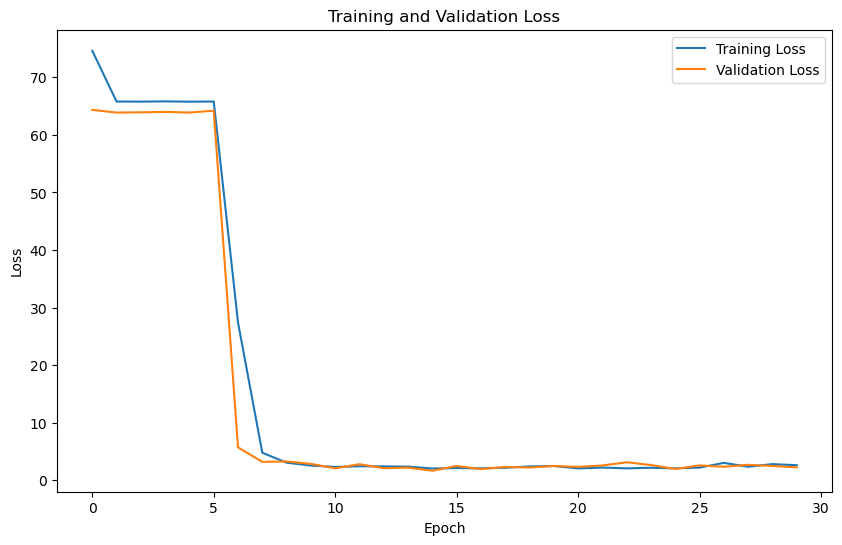

In [8]:
# plot the evolution of test and validation loss in order to prevent overfitting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [9]:
# import libraries to compare Monte Carlo predictions and the one done by the network
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib


In [10]:
# code taken from the creation of the dataset
def create_initial_config(N=None):
    states = [-1., 1.]
    config = np.random.choice(states, (N, N))
    return config

def metropolis_single_update(config=None, T=None, J=None):
    N, M = config.shape
    assert N == M, "Wrong configuration shape"
    i = np.random.randint(N)
    j = np.random.randint(M)
    s =  config[i, j]
    DeltaE = 2*s*(J[i,j,0]*config[i,(j-1)%N] + J[i,j,1]*config[i,(j+1)%N] + J[i,j,2]*config[(i+1)%N, j] + J[i,j,3]*config[(i-1)%N, j])
    effDeltaE = 0
    if DeltaE < 0:
        s *= -1
        effDeltaE = DeltaE
    else:
        if np.random.random() < np.exp(-DeltaE/T):
            s *= -1
            effDeltaE = DeltaE
    config[i, j] = s
    return effDeltaE

def create_vector(N, p):
    dim = (N-1)*N*2
    vector = np.ones(dim, dtype=int)
    negative_indices = np.random.choice(dim, p, replace=False)
    vector[negative_indices] = -1
    return vector

def create_spin_glass_dataset(N, v):
    J = np.zeros((N, N, 4), dtype=int)
    count = 0
    for i in range(N):
        for j in range(N):
            if j == 0:
                J[i, j, 0] = 0
            else:
                J[i, j, 0] = J[i, j-1, 1]
            if j == N-1:
                J[i, j, 1] = 0
            else:
                J[i, j, 1] = v[count]
                count = count + 1
            if i == 0:
                J[i, j, 2] = 0
            else:
                J[i, j, 2] = J[i-1, j, 3]
            if i == N-1:
                J[i, j, 3] = 0
            else:
                J[i, j, 3] = v[count]
                count = count + 1
    return J

def compute_q_EA(config_history):
    N = config_history.shape[1]
    avg_spins = np.mean(config_history, axis=0)
    q_EA = np.sum(avg_spins ** 2) / (N * N)
    return q_EA

def compute_total_energy(config, J):
    N, M = config.shape
    total_energy = 0
    for i in range(N):
        for j in range(M):
            s = config[i, j]
            total_energy -= s * (J[i, j, 0] * config[i, (j-1)%N] +
                                 J[i, j, 1] * config[i, (j+1)%N] +
                                 J[i, j, 2] * config[(i+1)%N, j] +
                                 J[i, j, 3] * config[(i-1)%N, j])
    return total_energy / 2  # to account for double-counting


In [11]:
# parameters
N = 6
T_values = np.arange(4, 0, -0.1)
T_values = np.append(T_values, 0.1)
n_updates = 100000

# generation of spin glass dataset
p = random.choice(range(0, (N-1) * N * 2 + 1))
v = create_vector(N, p)
J = create_spin_glass_dataset(N, v)

# initializing configuration
config = create_initial_config(N)


In [19]:
# Monte Carlo quantities
mc_energies = []
mc_q_EAs = []

for T in T_values:
    total_energy_sum = 0
    config_history = []
    total_measurements = 0

    for k in range(n_updates):
        DeltaE = metropolis_single_update(config, T=T, J=J)
        if k > 10000 and k % 100 == 0:
            config_history.append(config.copy())
            total_energy = compute_total_energy(config, J)
            total_energy_sum += total_energy
            total_measurements += 1

    average_energy = total_energy_sum / total_measurements
    config_history = np.array(config_history)
    q_EA = compute_q_EA(config_history)

    mc_energies.append(average_energy)
    mc_q_EAs.append(q_EA)


In [21]:
# code taken form preprocessing to create the dataset to pass to the Feed Forward Network
J_new = []

for i in range(N):
    for j in range(N-1):
        J_new.append(J[i, j, 1])  

for i in range(N-1):
    for j in range(N):
        J_new.append(J[i, j, 3]) 

J_new = np.array(J_new)


In [22]:
print(J_new.reshape(-1,1))

[[-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]]


In [15]:
print(T_values.reshape(-1,1))

[[4. ]
 [3.9]
 [3.8]
 [3.7]
 [3.6]
 [3.5]
 [3.4]
 [3.3]
 [3.2]
 [3.1]
 [3. ]
 [2.9]
 [2.8]
 [2.7]
 [2.6]
 [2.5]
 [2.4]
 [2.3]
 [2.2]
 [2.1]
 [2. ]
 [1.9]
 [1.8]
 [1.7]
 [1.6]
 [1.5]
 [1.4]
 [1.3]
 [1.2]
 [1.1]
 [1. ]
 [0.9]
 [0.8]
 [0.7]
 [0.6]
 [0.5]
 [0.4]
 [0.3]
 [0.2]
 [0.1]
 [0.1]]


In [23]:
model.eval()

# conversion in PyTorch tensor
J_flattened = J_new.reshape(1, -1)
T_values_tensor = torch.tensor(T_values.reshape(-1, 1), dtype=torch.float32)
J_tensors = torch.tensor(J_flattened, dtype=torch.float32).repeat(len(T_values), 1)
X_test = torch.cat((J_tensors, T_values_tensor), dim=1)

# Neural Network predictions
with torch.no_grad():
    y_pred = model(X_test)
    

# extracting energies and q_EA form network predictions
nn_energies = y_pred[:, 0]
nn_q_EAs = y_pred[:, 1]


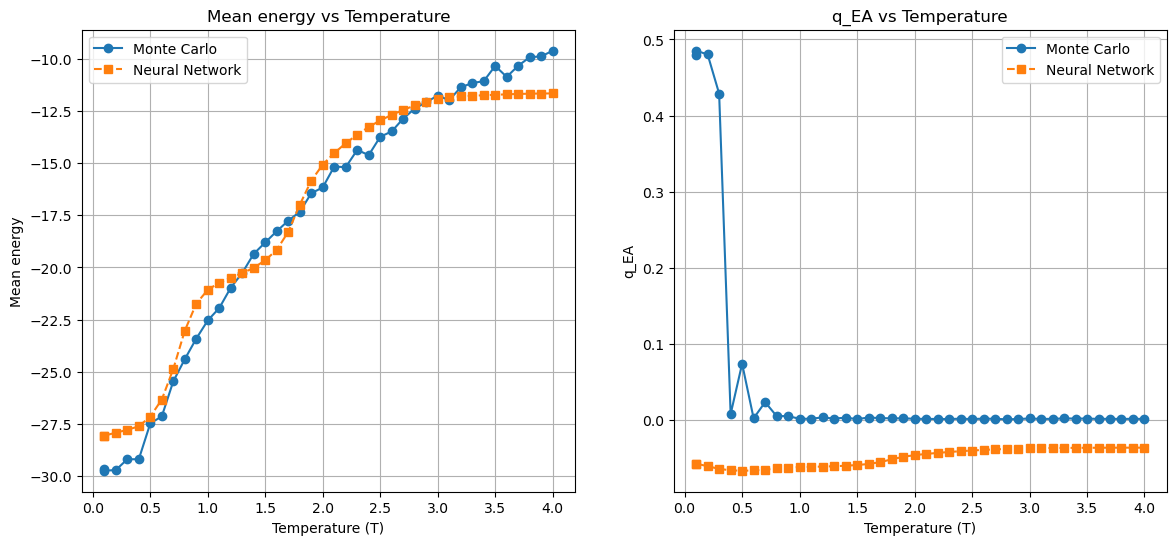

In [24]:
# compare results

plt.figure(figsize=(14, 6))

# mean energy 
plt.subplot(1, 2, 1)
plt.plot(T_values, mc_energies, 'o-', label='Monte Carlo')
plt.plot(T_values, nn_energies, 's--', label='Neural Network')
plt.xlabel('Temperature (T)')
plt.ylabel('Mean energy')
plt.title('Mean energy vs Temperature')
plt.legend()
plt.grid(True)

# q_EA
plt.subplot(1, 2, 2)
plt.plot(T_values, mc_q_EAs, 'o-', label='Monte Carlo')
plt.plot(T_values, nn_q_EAs, 's--', label='Neural Network')
plt.xlabel('Temperature (T)')
plt.ylabel('q_EA')
plt.title('q_EA vs Temperature')
plt.legend()
plt.grid(True)

plt.show()
